# Modeling All the Fire Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, ridge_regression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../../data/processed/wildfire_weather.csv')
df.head()

,id,x,y,containmentdatetime,controldatetime,dailyacres,discoveryacres,firecause,firediscoverydatetime,incidenttypecategory,...,wind_speed_10m_max,surface_soil_wetness_5cm_below,surface_soil_wetness_to_bedrock,wind_speed_2m_mean,wind_speed_2m_max_mean,wind_speed_10m_mean,wind_speed_10m_max_mean,humidity_mean,temp_2m_mean,rain_sum
0,0,-111.348611,33.195755,2020-07-23 05:29:59+00:00,2020-07-23 05:29:59+00:00,8.0,2.5,Human,2020-07-22 21:51:00+00:00,WF,...,3.84,0.12,0.38,1.410000,3.090000,1.895000,4.180000,13.210000,29.900000,2.60
1,1,-115.748812,40.617506,2020-08-03 23:00:00+00:00,2020-09-02 15:00:00+00:00,5985.9,5.0,Natural,2020-07-19 23:00:00+00:00,WF,...,4.52,0.31,0.37,1.933913,3.914783,2.865217,5.237174,5.657391,23.396304,12.62
2,2,-108.193611,39.858486,2020-08-30 00:00:00+00:00,2020-09-10 14:00:00+00:00,0.1,1.0,Natural,2020-08-29 21:46:00+00:00,WF,...,5.82,0.26,0.35,1.733846,2.986154,2.993846,4.754615,4.731538,16.121538,27.78
3,3,-109.703111,40.227646,2020-10-28 20:15:00+00:00,2020-10-28 20:15:00+00:00,0.1,0.1,Human,2020-10-28 19:37:00+00:00,WF,...,4.02,0.17,0.34,1.250000,2.980000,1.880000,4.020000,2.560000,5.480000,0.00
4,4,-110.385511,31.961145,2020-07-10 18:14:59+00:00,2020-07-10 18:14:59+00:00,0.1,0.1,Human,2020-07-09 16:34:59+00:00,WF,...,5.90,0.15,0.36,3.090000,5.055000,4.265000,6.800000,9.950000,31.235000,0.58


In [3]:
for i in df.columns:
    print(i)

x
y
containmentdatetime
controldatetime
dailyacres
discoveryacres
firecause
firediscoverydatetime
incidenttypecategory
incidenttypekind
initiallatitude
initiallongitude
irwinid
localincidentidentifier
poocounty
poodispatchcenterid
poofips
poostate
uniquefireidentifier
temp_2m
temp_2m_max
humidity
rain
wind_speed_2m
wind_speed_2m_max
wind_speed_10m
wind_speed_10m_max
surface_soil_wetness_5cm_below
surface_soil_wetness_to_bedrock
rain_mean
wind_speed_2m_mean_x
wind_speed_2m_max_mean_x
wind_speed_10m_mean_x
wind_speed_10m_max_mean_x
humidity_mean_x
temp_2m_mean_x
wind_speed_2m_mean_y
wind_speed_2m_max_mean_y
wind_speed_10m_mean_y
wind_speed_10m_max_mean_y
humidity_mean_y
temp_2m_mean_y
rain_sum


In [4]:
df['firediscoverydatetime'] = pd.to_datetime(df['firediscoverydatetime'])
df['controldatetime'] = pd.to_datetime(df['controldatetime'])
df['containmentdatetime'] = pd.to_datetime(df['containmentdatetime'])

In [5]:
df['time_to_control'] = df['controldatetime'] - df['firediscoverydatetime']
df['time_to_contain'] = df['containmentdatetime'] - df['firediscoverydatetime']

df['minutes_to_control'] = df['time_to_control'].map(lambda x: x.total_seconds()/60)
df['minutes_to_contain'] = df['time_to_contain'].map(lambda x: x.total_seconds()/60)

In [6]:
df['firecause'].value_counts()

Human           9583
Natural         6326
Undetermined    4986
Unknown          642
Name: firecause, dtype: int64

In [7]:
df['firecause'] = df['firecause'].map({'Undetermined': 0, 'Unknown': 0, 'Natural': 1, 'Human' : 2})

---
######
### Investigating Correlation Between the Features and Target (DailyAcres) 
######
___

In [8]:
heatmap_cols = ['dailyacres', 'discoveryacres', 'minutes_to_control','minutes_to_contain', 'firecause', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 
                'wind_speed_2m_max', 'wind_speed_10m', 'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 
                'rain_mean', 'wind_speed_2m_mean_x', 'wind_speed_2m_max_mean_x', 'wind_speed_10m_mean_x', 'wind_speed_10m_max_mean_x', 
                'humidity_mean_x', 'temp_2m_mean_x', 'wind_speed_2m_mean_y', 'wind_speed_2m_max_mean_y', 'wind_speed_10m_mean_y', 
                'wind_speed_10m_max_mean_y', 'humidity_mean_y', 'temp_2m_mean_y', 'rain_sum']

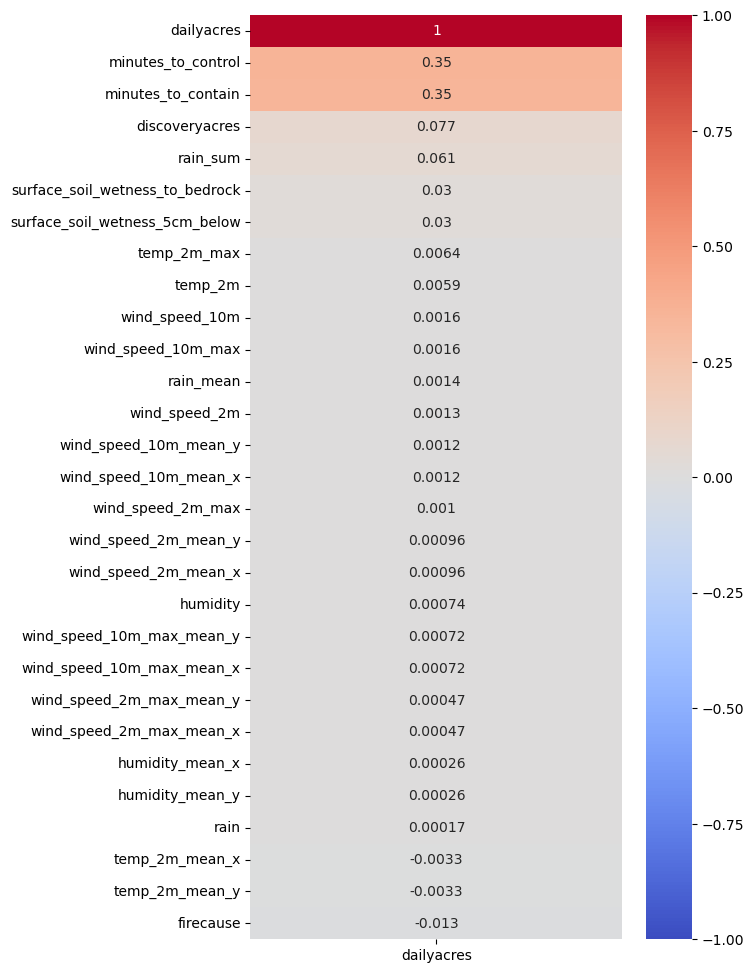

In [10]:
plt.figure(figsize = (6, 12))
sns.heatmap(df[heatmap_cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

---
######
### Briefly Investigating Correlation Between the Features and Target (DailyAcres) for Fires Equal to / Over 1 Acre
######
___

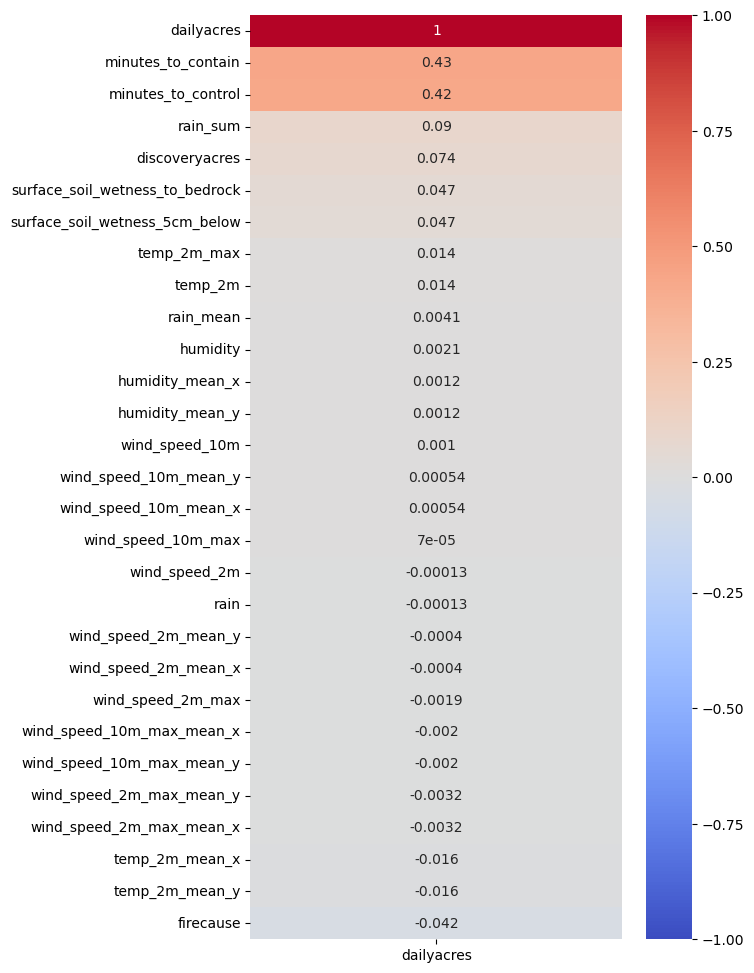

In [11]:
df_over_1_acre = df[df['dailyacres'] >=1.0]
plt.figure(figsize = (6, 12))
sns.heatmap(df_over_1_acre[heatmap_cols].corr()[['dailyacres']].sort_values(by = 'dailyacres', ascending=False),
            vmin = -1,
            vmax = 1, 
            cmap = 'coolwarm',
            annot = True);

In [12]:
df_over_1_acre.shape

(4916, 47)

In [13]:
df.shape

(21537, 47)

---
######
### Feature Selection, Train/Test Splitting Data, and Standard Scaling
######
___

In [14]:
cols = ['dailyacres', 'discoveryacres', 'firecause', 'temp_2m', 'temp_2m_max', 'humidity', 'rain', 'wind_speed_2m', 
                'wind_speed_2m_max', 'wind_speed_10m', 'wind_speed_10m_max', 'surface_soil_wetness_5cm_below', 'surface_soil_wetness_to_bedrock', 
                'rain_mean', 'wind_speed_2m_mean_x', 'wind_speed_2m_max_mean_x', 'wind_speed_10m_mean_x', 'wind_speed_10m_max_mean_x', 
                'humidity_mean_x', 'temp_2m_mean_x', 'wind_speed_2m_mean_y', 'wind_speed_2m_max_mean_y', 'wind_speed_10m_mean_y', 
                'wind_speed_10m_max_mean_y', 'humidity_mean_y', 'temp_2m_mean_y', 'rain_sum']

In [15]:
pca = PCA(random_state = 42)
df = df[cols]

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = 'dailyacres'), df['dailyacres'], random_state= 42)

In [16]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

---
######
### Using PCA For Feature Elimination
######
___

In [17]:
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [18]:
explained = pca.explained_variance_ratio_
cumulative = np.cumsum(explained)
np.round(cumulative[:20], 3)

array([0.736, 0.826, 0.901, 0.94 , 0.965, 0.989, 0.997, 0.999, 0.999,
       1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   , 1.   ,
       1.   , 1.   ])

In [19]:
Z_train = Z_train[:,:10]
Z_test = Z_test[:,:10]

In [25]:
#Saving the PCA data for investigations in Neural Nets
np.savetxt('../../data/processed/Z_train.csv', Z_train, delimiter=',')
np.savetxt('../../data/processed/Z_test.csv', Z_test, delimiter=',')
np.savetxt('../../data/processed/y_train.csv', y_train, delimiter=',')
np.savetxt('../../data/processed/y_test.csv', y_test, delimiter=',')

In [ ]:
---
######
### Modeling  
######
___

In [56]:
#Linear Regression - Baseline
# With X data
lr = LinearRegression()

lr.fit(X_train, y_train)
print(f'Training R-Squared: {lr.score(X_train, y_train)}')
print(f'Testing R-Squared: {lr.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(X_test), squared = False)}')

Training R-Squared: 0.0492391111018341
Testing R-Squared: 0.04661002884838039
RMSE: 6105.022697614408


In [55]:
#Linear Regression - Baseline
# With PCA Data
lr = LinearRegression()

lr.fit(Z_train, y_train)
print(f'Training R-Squared: {lr.score(Z_train, y_train)}')
print(f'Testing R-Squared: {lr.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, lr.predict(Z_test), squared = False)}')

Training R-Squared: 0.02599914527915359
Testing R-Squared: 0.010760861012771183
RMSE: 6218.743422107511


In [74]:
def model_eval(model, param_dict, training_data):
    '''
    d
    '''
    
    gs_model = GridSearchCV(model,
                            param_grid = param_dict,
                            n_jobs = -1)
    if training_data == 'X_train':
        gs_model.fit(X_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(X_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(X_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(X_test, y_test)}')
        
    elif training_data == 'Z_train':
        gs_model.fit(Z_train, y_train)
        print(f'Best Score: {gs_model.best_score_}')
        print(f'Best Params: {gs_model.best_params_}')
        print('='*50)
        print(f'RMSE: {mean_squared_error(y_test, gs_model.predict(Z_test), squared = False)}')
        print('='*50)
        print(f'Training R-Squared: {gs_model.score(Z_train, y_train)}')
        print(f'Testing R-Squared: {gs_model.score(Z_test, y_test)}')
    else:
        return 'Try Again'

In [80]:
#KNN Regressor with X Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'X_train')

Best Score: 0.019112073018724286
Best Params: {'n_neighbors': 1000, 'weights': 'distance'}
RMSE: 6179.017464619431
Training R-Squared: 0.9956659831913355
Testing R-Squared: 0.02335921023841725


In [81]:
#KNN Regressor with PCA Data

knn_model = KNeighborsRegressor(n_jobs=-1)

knn_params = {
    'n_neighbors': range(1000, 2001, 100),
    'weights': ['uniform', 'distance']
}

model_eval(model = knn_model,
           param_dict = knn_params,
           training_data = 'Z_train')

Best Score: 0.02003454974637453
Best Params: {'n_neighbors': 1000, 'weights': 'distance'}
RMSE: 6176.462505383479
Training R-Squared: 0.9956659742921743
Testing R-Squared: 0.024166704806837136


In [82]:
# Lasso Regression with X Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'X_train')

Best Score: 0.01859308701054958
Best Params: {'alpha': 7}
RMSE: 6163.003211356567
Training R-Squared: 0.04068128966678297
Testing R-Squared: 0.028414999644036154


C:\Users\jeffr\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.257e+10, tolerance: 7.663e+07
  model = cd_fast.enet_coordinate_descent(


In [83]:
# Lasso Regression with PCA Data

lasso = Lasso()
lasso_params = {
    'alpha': range(5, 101, 2)
}

model_eval(model = lasso,
           param_dict = lasso_params,
           training_data = 'Z_train')

Best Score: 0.011162574978104578
Best Params: {'alpha': 35}
RMSE: 6233.225615938861
Training R-Squared: 0.02040531819976854
Testing R-Squared: 0.006148020903463114


In [86]:
# Adaboost with X Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'X_train')

Best Score: -0.8821180182895834
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 6381.416769321106
Training R-Squared: 0.5472774503986891
Testing R-Squared: -0.041670180258196465


In [87]:
# Adaboost with PCA Data

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators': range(40, 101, 10),
    'learning_rate': [0.5, 0.75, 1, 1.25, 1.5] 
}

model_eval(model = ada,
           param_dict = ada_params,
           training_data = 'Z_train')

Best Score: -0.7226108829098994
Best Params: {'learning_rate': 0.5, 'n_estimators': 40}
RMSE: 6587.445722135626
Training R-Squared: 0.540797274970481
Testing R-Squared: -0.11001823426986612


In [57]:
# Stacking Regressor with Z_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: -0.665183675674186
Testing R-Squared: -1.329365828862259
RMSE: 9542.690608388644


In [58]:
# Stacking Regressor with X_train

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=DecisionTreeRegressor(),
                         n_jobs=-1)

stack.fit(X_train, y_train)

print(f'Training R-Squared: {stack.score(X_train, y_train)}')
print(f'Testing R-Squared: {stack.score(X_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(X_test), squared = False)}')

Training R-Squared: -0.3294699362845459
Testing R-Squared: -0.7911446500665642
RMSE: 8367.916221278168


In [59]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=LinearRegression(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.388392632271471
Testing R-Squared: 0.10308886313885379
RMSE: 5921.431390717258


In [60]:
# Stacking Regressor

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.36829782661161214
Testing R-Squared: 0.10263671420713849
RMSE: 5922.923752348845


In [61]:
# Stacking Regressor

lvl1_est = ([
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

stack = StackingRegressor(estimators=lvl1_est, 
                          final_estimator=Lasso(),
                         n_jobs=-1)

stack.fit(Z_train, y_train)

print(f'Training R-Squared: {stack.score(Z_train, y_train)}')
print(f'Testing R-Squared: {stack.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, stack.predict(Z_test), squared = False)}')

Training R-Squared: 0.16917662957589852
Testing R-Squared: 0.043167416258513835
RMSE: 6116.035132160507


In [62]:
#Voting Classifier

lvl1_est = ([
    ('rf', RandomForestRegressor(n_jobs=-1)),
    ('ada', AdaBoostRegressor()),
    ('lasso', Lasso())
])

vote = VotingRegressor(estimators = lvl1_est, n_jobs = -1)

vote.fit(Z_train, y_train)
print(f'Training R-Squared: {vote.score(Z_train, y_train)}')
print(f'Testing R-Squared: {vote.score(Z_test, y_test)}')
print('='*50)
print(f'RMSE: {mean_squared_error(y_test, vote.predict(Z_test), squared = False)}')

Training R-Squared: 0.19924171963242732
Testing R-Squared: -0.4346389554736585
RMSE: 7488.990901646875


<module 'xgboost' from 'C:\\Users\\jeffr\\anaconda3\\lib\\site-packages\\xgboost\\__init__.py'>